<a href="https://colab.research.google.com/github/kindeerrrr/first_repository/blob/main/dz_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Импорт библиотек

In [222]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

import lightgbm as lgb
from sklearn.metrics import accuracy_score

Чтение и работа с пропусками

In [223]:
# Загружаем обучающую и тестовую выборки
train = pd.read_csv("train_oil.csv")
test = pd.read_csv("oil_test.csv")

# Проверяем размерность датасетов
print(f"Train dataset shape: {train.shape}")
print(f"Test dataset shape: {test.shape}")

# Анализ пропущенных значений в обучающем наборе
df_nan = train.loc[:, train.isnull().any()]
print("Missing values (%):")
print(df_nan.isnull().sum() / len(train) * 100)

# Удаляем строки с пропущенными значениями (значений мало, поэтому можно удалить, а не заменить)
train = train.dropna()

# Быстрый просмотр структуры датафрейма
train.info()

Train dataset shape: (309, 20)
Test dataset shape: (133, 19)
Missing values (%):
Country        8.737864
Region        12.297735
Basin name    12.297735
Latitude       8.737864
Longitude      9.708738
dtype: float64
<class 'pandas.core.frame.DataFrame'>
Index: 268 entries, 0 to 308
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Field name                      268 non-null    object 
 1   Reservoir unit                  268 non-null    object 
 2   Country                         268 non-null    object 
 3   Region                          268 non-null    object 
 4   Basin name                      268 non-null    object 
 5   Tectonic regime                 268 non-null    object 
 6   Latitude                        268 non-null    float64
 7   Longitude                       268 non-null    float64
 8   Operator company                268 non-null    object 
 9   Onshore/

Пропусков больше не осталось

Далее работаем с целевой переменной

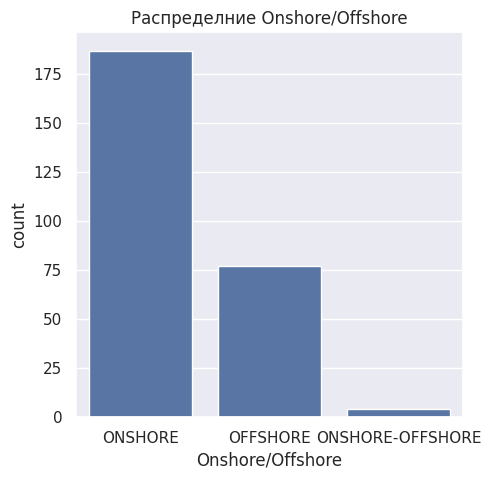

Onshore/Offshore
ONSHORE             187
OFFSHORE             77
ONSHORE-OFFSHORE      4
Name: count, dtype: int64


In [224]:
# Визуализируем распределение классов в целевой переменной
sns.set(rc={'figure.figsize': (5, 5)})
y_data = pd.DataFrame(train['Onshore/Offshore'])
sns.countplot(x='Onshore/Offshore', data=y_data)
plt.title("Распределние Onshore/Offshore")
plt.show()

# Считаем количество объектов каждого класса
print(train['Onshore/Offshore'].value_counts())

# Преобразуем категории целевой переменной в числовые значения
class_mapping = {'ONSHORE': 1, 'OFFSHORE': 0, 'ONSHORE-OFFSHORE': 2}
train['Onshore/Offshore'] = train['Onshore/Offshore'].map(class_mapping)

Данные несбалансированы (187/77)

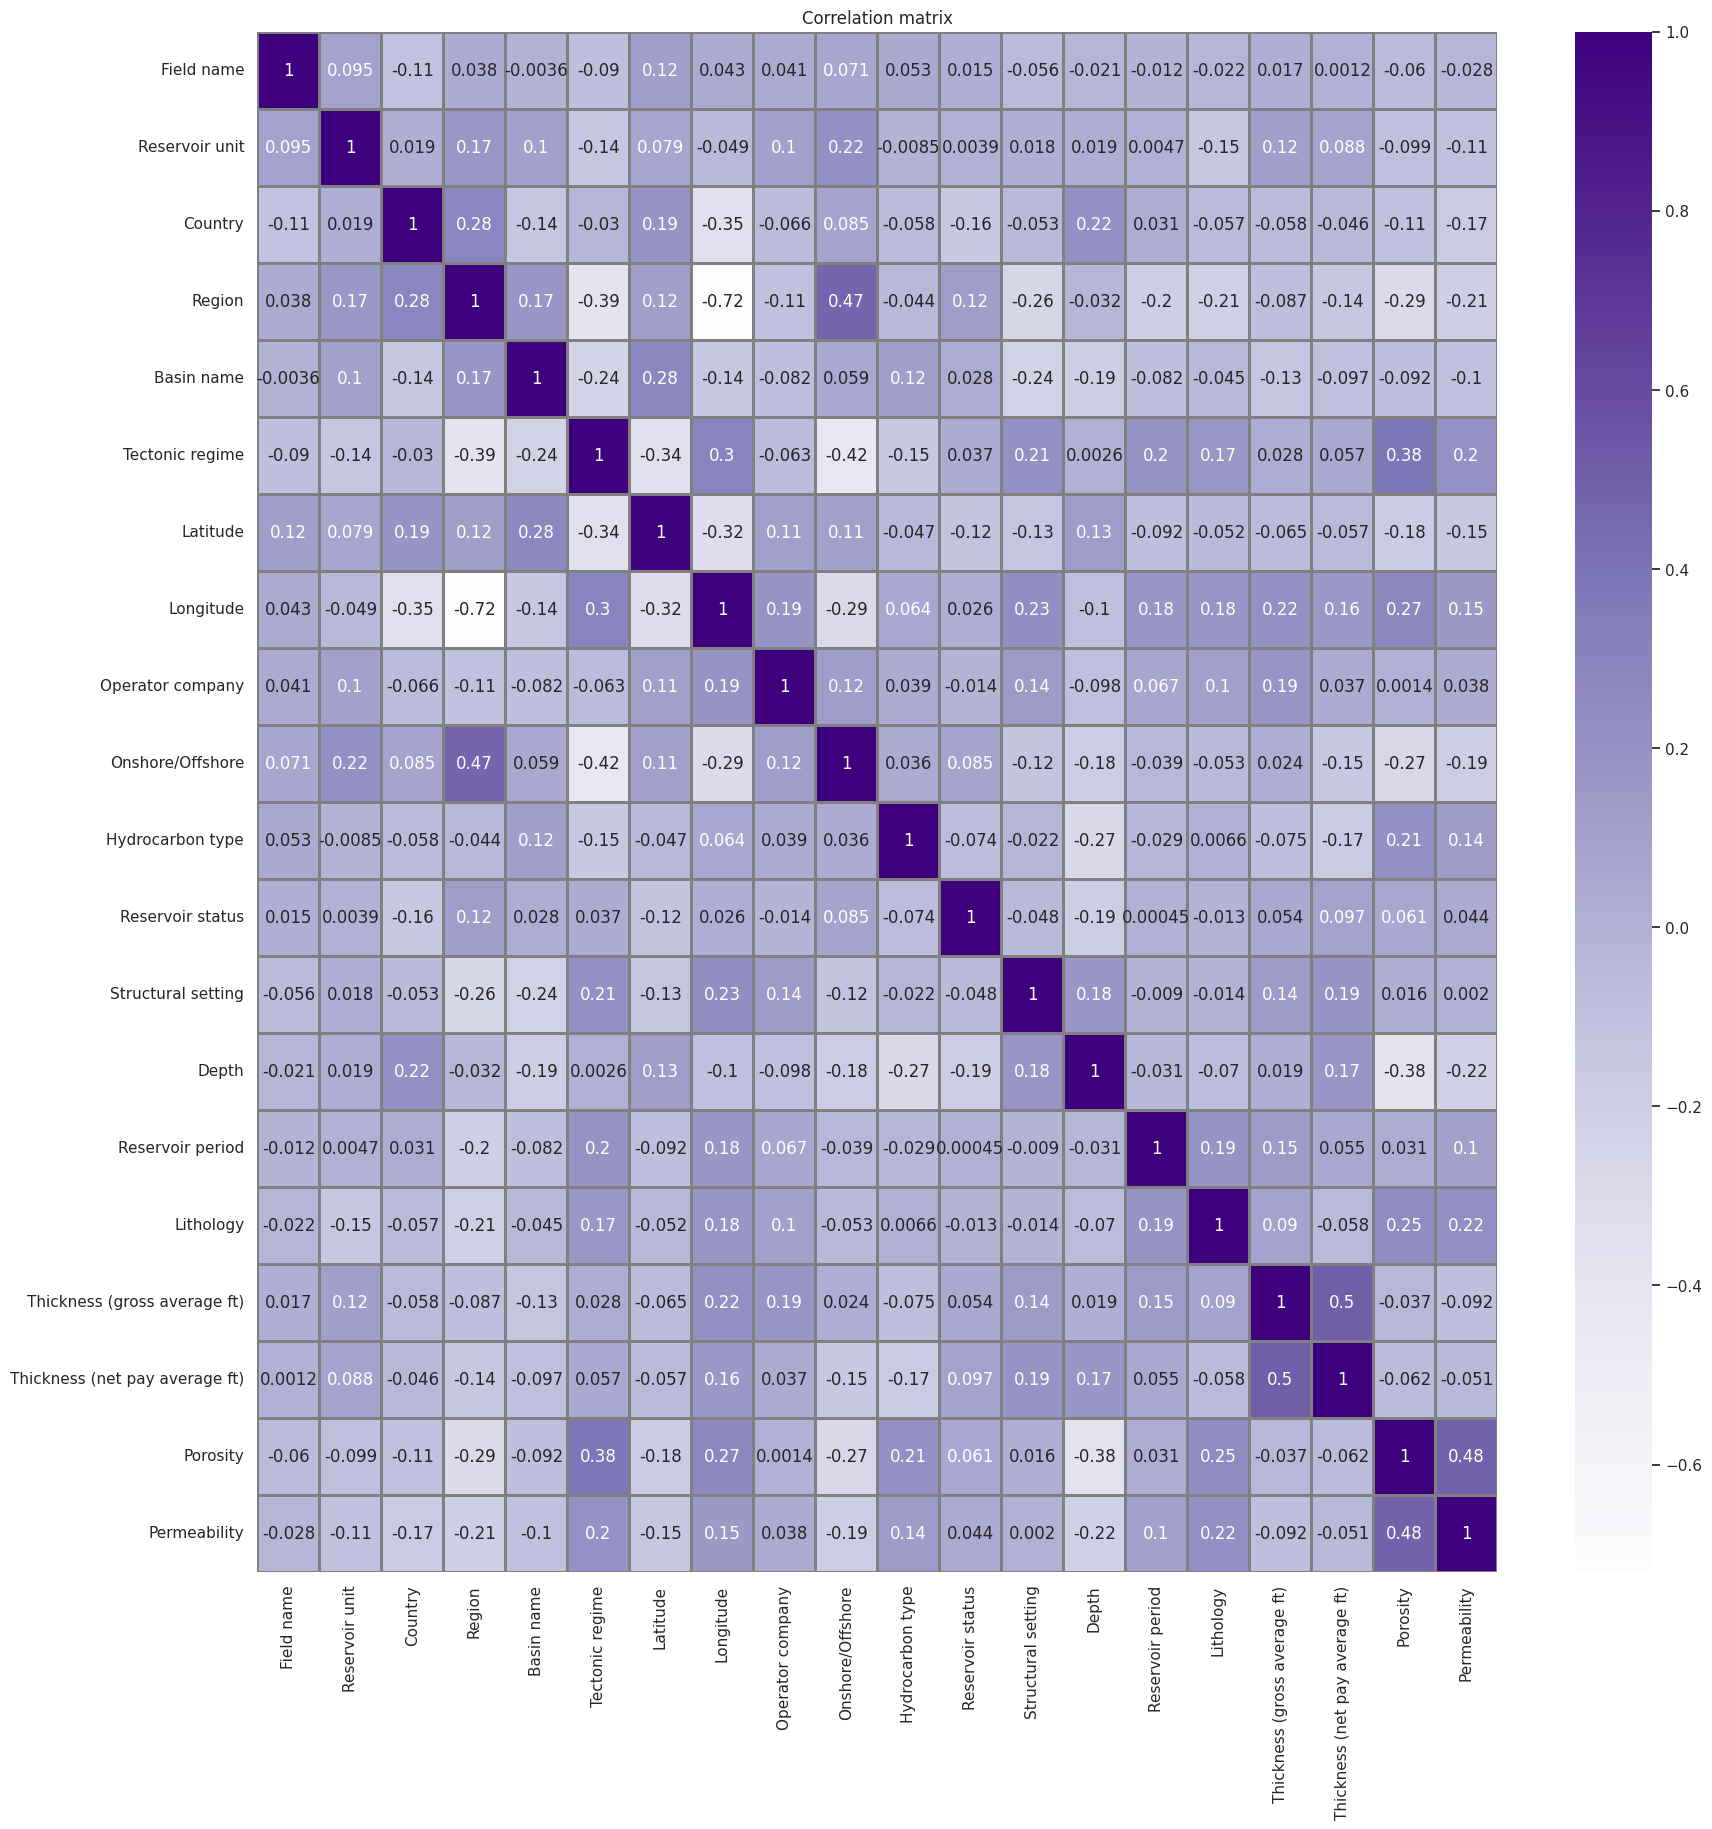

In [225]:
# Указываем признаки с категориальными значениями
categorical_cols = ['Hydrocarbon type', 'Reservoir status', 'Reservoir period', 'Lithology',
                    'Tectonic regime', 'Structural setting', 'Field name', 'Reservoir unit',
                    'Country', 'Region', 'Basin name', 'Operator company']

# Инициализируем кодировщик с обработкой неизвестных категорий
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# Применяем кодировщик к категориальным столбцам
train[categorical_cols] = encoder.fit_transform(train[categorical_cols])
test[categorical_cols] = encoder.transform(test[categorical_cols])

# Построим тепловую карту корреляции между числовыми признаками
sns.set(rc={'figure.figsize': (20, 20)})
sns.heatmap(train.corr(numeric_only=True), annot=True, cmap="Purples", linecolor='gray', linewidths=1)
plt.title("Correlation matrix")
plt.show()

# Удалим признаки, которые показали слабую корреляцию или избыточную информацию
drop_cols = ['Field name', 'Country', 'Basin name', 'Hydrocarbon type',
             'Reservoir status', 'Reservoir period', 'Lithology', 'Thickness (gross average ft)']
train = train.drop(columns=drop_cols)
test = test.drop(columns=drop_cols)

# Разделим обучающую выборку на признаки и целевую переменную
X = train.drop(columns=['Onshore/Offshore'])
y = train['Onshore/Offshore']

In [213]:
cor = train.corr(numeric_only=True)
target_corr = cor['Onshore/Offshore'].drop('Onshore/Offshore')
print(target_corr.sort_values(ascending=False))

Region                            0.473544
Reservoir unit                    0.218507
Operator company                  0.122282
Latitude                          0.111805
Structural setting               -0.115848
Thickness (net pay average ft)   -0.151302
Depth                            -0.184756
Permeability                     -0.190866
Porosity                         -0.268944
Longitude                        -0.293879
Tectonic regime                  -0.424822
Name: Onshore/Offshore, dtype: float64


Как мы видим, лучше всего кореллирует параметр Region  

Уменьшим дисбаланс в данных методом SMOTE

In [214]:
# Применим метод увеличения данных для борьбы с дисбалансом классов
smote = SMOTE(random_state=0, k_neighbors=2)
os_data_X, os_data_y = smote.fit_resample(X, y)

# Оборачиваем в DataFrame для совместимости с визуализациями
os_data_X = pd.DataFrame(os_data_X, columns=X.columns)
os_data_y = pd.DataFrame(os_data_y, columns=['Onshore/Offshore'])

print(f'Features shape after SMOTE: {os_data_X.shape}')
print("Classes distribution after SMOTE:")
print(os_data_y.value_counts())

Features shape after SMOTE: (561, 11)
Classes distribution after SMOTE:
Onshore/Offshore
0                   187
1                   187
2                   187
Name: count, dtype: int64


После уравнивания значений можно разбить данные на тренировочную и валидационную выборки

In [216]:
# Делим данные на тренировочную и валидационную выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=45, stratify=y
)

print(f'Train dataset size: {X_train.shape}, {y_train.shape}')
print(f'Test dataset size: {X_test.shape}, {y_test.shape}')

Train dataset size: (214, 11), (214,)
Test dataset size: (54, 11), (54,)


Далее можем обучить разные модели, оценить точность предсказаний каждой из моделей:


1.   Дерево решений;
2.   Ближайшие соседи;
3.   Случайный лес.

После этого выберем наилучшую модель



In [197]:
import xgboost as xgb

models = {
    'Decision Tree': DecisionTreeClassifier(),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Random Forest': RandomForestClassifier(n_estimators=100, criterion='gini', random_state=42),
}

# Обучение и оценка моделей
for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    acc = accuracy_score(y_test, predictions)
    print(f"Accuracy of {name}: {acc:.4f}")

Accuracy of Decision Tree: 0.8148
Accuracy of KNN: 0.7593
Accuracy of Random Forest: 0.8333


Лучший результат у случайного леса.

Построим матрицу ошибок для выбранных моделей

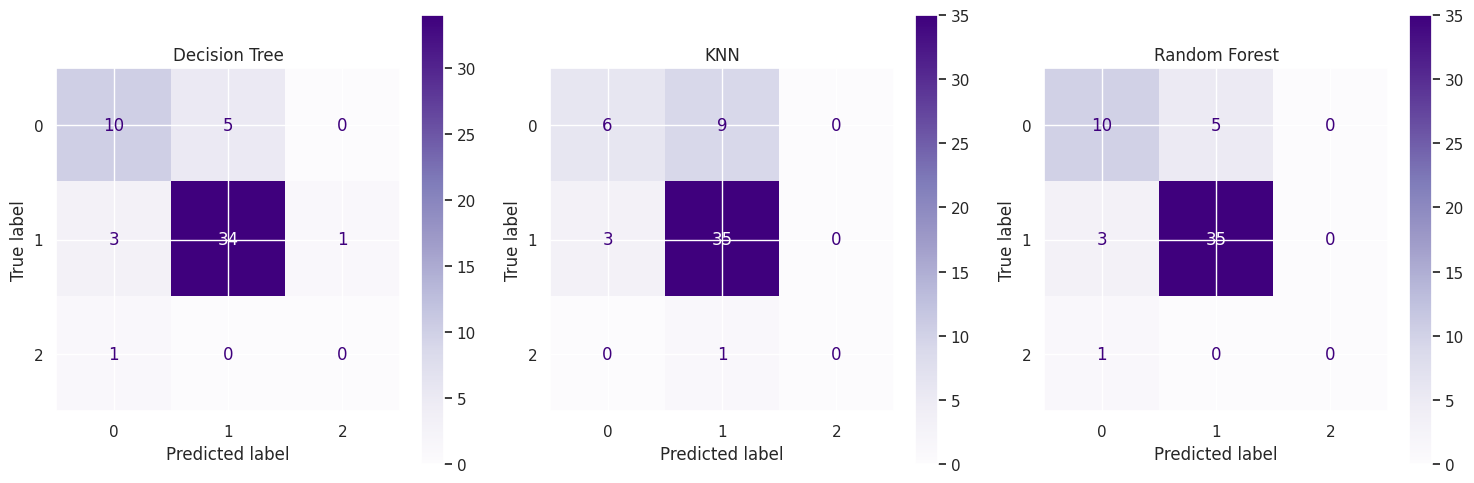

In [198]:
# Визуализация матриц ошибок
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for idx, (name, model) in enumerate(models.items()):
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, ax=axes[idx], cmap='Purples')
    axes[idx].set_title(name)

plt.tight_layout()
plt.show()

Чтобы улучшить качество модели случайного леса, было решено провести поиск оптимального количества деревьев (n_estimators)

In [207]:
print("Подбор числа деревьев (n_estimators) для Random Forest:")
# Подбираем оптимальное количество деревьев в случайном лесе
for i in range(1, 21):
    estimators = i * 10
    rf_i = RandomForestClassifier(n_estimators=estimators, criterion='gini', random_state=42)
    rf_i.fit(X_train, y_train)
    y_pred_rf_i = rf_i.predict(X_test)
    print(f'Accuracy rf with {estimators} estimators: {accuracy_score(y_test, y_pred_rf_i)}')

Подбор числа деревьев (n_estimators) для Random Forest:
Accuracy rf with 10 estimators: 0.8518518518518519
Accuracy rf with 20 estimators: 0.8518518518518519
Accuracy rf with 30 estimators: 0.8333333333333334
Accuracy rf with 40 estimators: 0.8518518518518519
Accuracy rf with 50 estimators: 0.8703703703703703
Accuracy rf with 60 estimators: 0.8518518518518519
Accuracy rf with 70 estimators: 0.8518518518518519
Accuracy rf with 80 estimators: 0.8518518518518519
Accuracy rf with 90 estimators: 0.8518518518518519
Accuracy rf with 100 estimators: 0.8333333333333334
Accuracy rf with 110 estimators: 0.8333333333333334
Accuracy rf with 120 estimators: 0.8333333333333334
Accuracy rf with 130 estimators: 0.8333333333333334
Accuracy rf with 140 estimators: 0.8333333333333334
Accuracy rf with 150 estimators: 0.8333333333333334
Accuracy rf with 160 estimators: 0.8518518518518519
Accuracy rf with 170 estimators: 0.8518518518518519
Accuracy rf with 180 estimators: 0.8333333333333334
Accuracy rf with 

In [208]:
# Предсказание целевой переменной на основе тестовой выборки
y_test_pred = rf.predict(test)

# Формируем датафрейм с ответами
ans_df = pd.DataFrame(y_test_pred, columns=['Onshore/Offshore '])

# Добавляем индекс (если нужно Kaggle)
ans_df.reset_index(inplace=True)

# Сохраняем результаты в .csv файл
ans_df.to_csv('submition.csv', index=False)

Попробовав разные методы, в том числе:


*   Применение другой модели:
    *   XGBoost
    *   LightGBM

*   Изменение параметров:
    *   random_state для Случайного леса;
    *   применение гиперпараметровдля Случайного леса

 пришлось остановиться на первоначальном варианте:

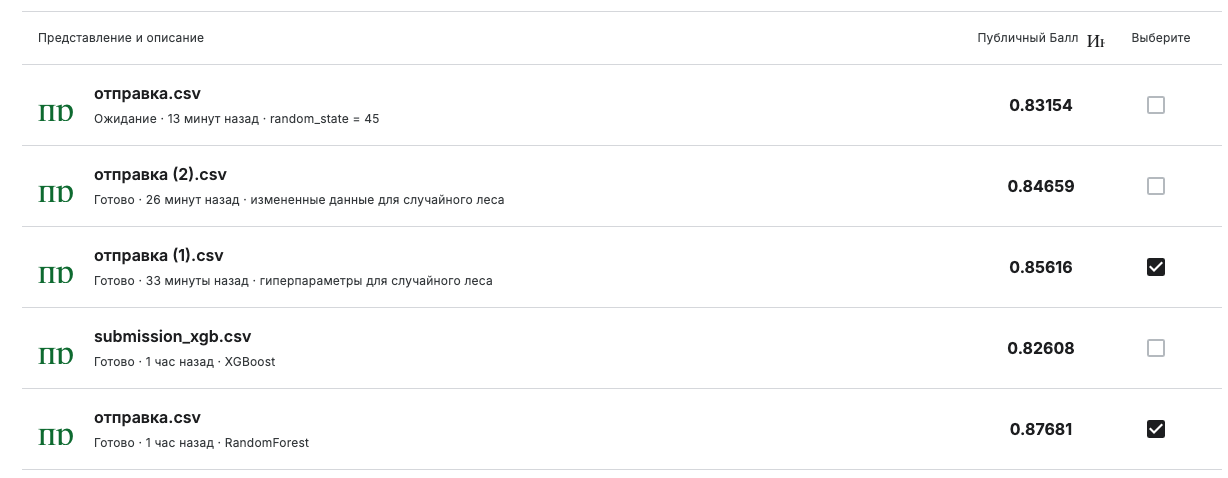

Место в таблице:

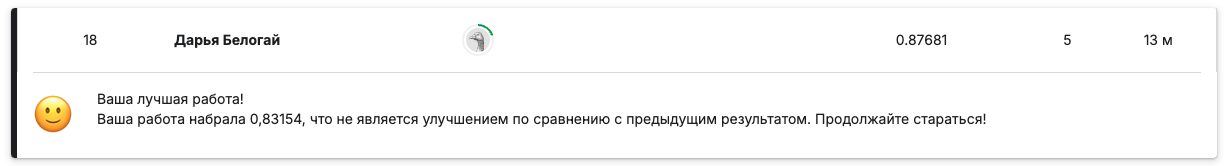